In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit,njit,float64,int32
import numba as nb
import pandas as pd
from derivative import dxdt


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Frailty Index Model

# $\frac{df}{dt} = (1-f) \cdot a \cdot (1+bt) - f(r-st)$

# Mortality Models

# $\mu = f(t)^c$

# $\mu = \mu_0 e^{d\cdot f}$

In [206]:
import numpy as np
def frailty_index_differential_equation(f, t, a, b, r, s):
    dydt = a*(1-f)*(1+b*t) - f*(r - s*t)
    return dydt

In [207]:
y0 = 0.0

In [208]:
t = np.linspace(0, 100, 101)

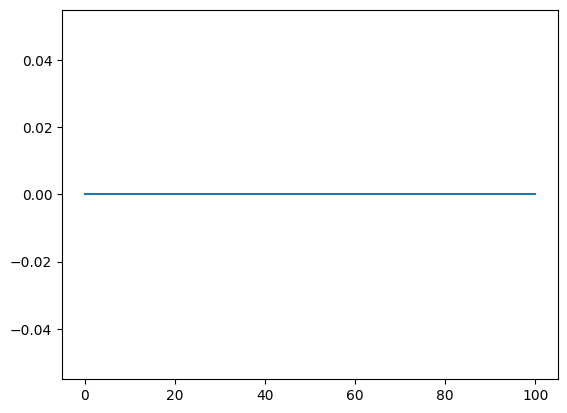

In [209]:
a = 0.0
b = 0.0
r = 0.0
s = 0.0

from scipy.integrate import odeint
sol = odeint(frailty_index_differential_equation, y0, t, args=(a, b, r, s))
plt.plot(t, sol)

In [210]:
c = 50
frailty_index = []
for i in sol:
    frailty_index.append(i[0])
frailty_index = np.array(frailty_index)
gompertz_law_differential_equation = frailty_index**c

In [211]:
parametro_beta = []
parametro_R = []



data = gompertz_law_differential_equation
derivative_process = dxdt(data, t, kind="finite_difference", k=1)

beta_values = derivative_process/data
R_values = data/np.e**(beta_values*t)

parametro_R.append(R_values)
parametro_beta.append(beta_values)

/var/folders/b8/c7tcpgms33l8z7x93t10121w0000gn/T/ipykernel_10085/3834456628.py:9: RuntimeWarning: invalid value encountered in divide
  beta_values = derivative_process/data


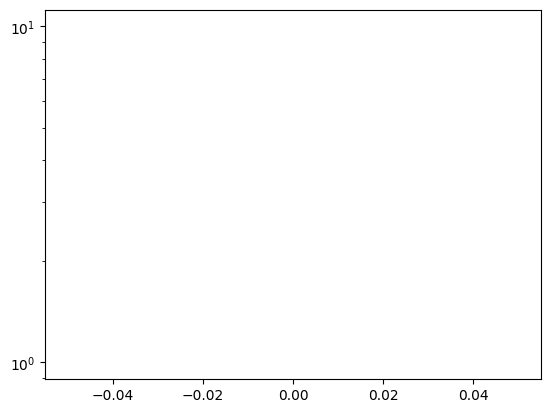

In [212]:
plt.scatter(parametro_beta, parametro_R)
plt.yscale("log")